In [1]:
# Install necessary libraries
!pip install shap pandas numpy pillow tensorflow scikit-learn pyarrow matplotlib seaborn

import shap
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from PIL import Image

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [2]:
def extract_bytes(blob):
    """Extracts byte data from various potential formats in the dataframe."""
    if isinstance(blob, dict):
        for key in ("bytes", "data", "image"):
            if key in blob and isinstance(blob[key], (bytes, bytearray)):
                return blob[key]
        for v in blob.values():
            if isinstance(v, (bytes, bytearray)):
                return v
        raise TypeError("No bytes found in dict payload")
    return blob

def bytes_to_pixels(b: bytes, target_size=(128, 128)) -> np.ndarray:
    """Converts image bytes to a normalized numpy array."""
    img = Image.open(io.BytesIO(b)).convert("L") # Convert to Grayscale
    img = img.resize(target_size)
    return np.array(img)

def preprocess_dataframe(df):
    """Loads images and labels from the dataframe."""
    images, labels = [], []
    for _, row in df.iterrows():
        img_bytes = extract_bytes(row['image'])
        # Normalize pixel values to 0-1
        images.append(bytes_to_pixels(img_bytes) / 255.0)
        labels.append(row['label'])

    # Reshape to (Batch_Size, Height, Width, Channels)
    X = np.array(images).reshape(-1, 128, 128, 1)
    y = np.array(labels)
    return X, y

In [3]:
# 1. Load Data
print("Loading Parquet files...")
train_df = pd.read_parquet("train.parquet")
test_df = pd.read_parquet("test.parquet")

X_train, y_train = preprocess_dataframe(train_df)
X_test, y_test = preprocess_dataframe(test_df)

# 2. Prepare Labels
num_classes = len(np.unique(y_train))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

print(f"Training Data Shape: {X_train.shape}")
print(f"Number of Classes: {num_classes}")

# 3. Build Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 4. Train (Fast - 4 Epochs)
print("\nStarting fast training...")
history = model.fit(
    X_train, y_train_cat,
    epochs=4,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Loading Parquet files...
Training Data Shape: (5120, 128, 128, 1)
Number of Classes: 4


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Starting fast training...
Epoch 1/4
128/128 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.4774 - loss: 1.0592 - val_accuracy: 0.6104 - val_loss: 0.8844
Epoch 2/4
128/128 ━━━━━━━━━━━━━━━━━━━━ 125s 974ms/step - accuracy: 0.5891 - loss: 0.8807 - val_accuracy: 0.6367 - val_loss: 0.7644
Epoch 3/4
128/128 ━━━━━━━━━━━━━━━━━━━━ 141s 971ms/step - accuracy: 0.6794 - loss: 0.7138 - val_accuracy: 0.7812 - val_loss: 0.5089
Epoch 4/4
128/128 ━━━━━━━━━━━━━━━━━━━━ 124s 968ms/step - accuracy: 0.8073 - loss: 0.4686 - val_accuracy: 0.8545 - val_loss: 0.3668


Explaining Image Index: 273 (True Class: Class 3)
Calculating SHAP values...


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1, 128, 128, 1))']
  warnings.warn(msg)


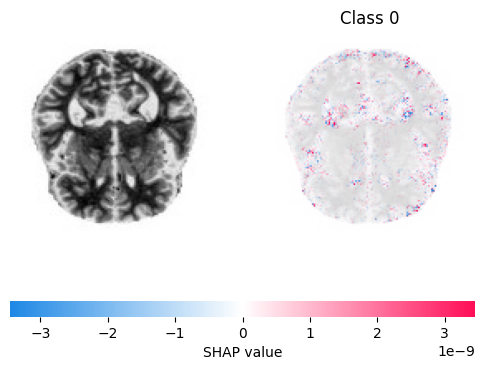

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


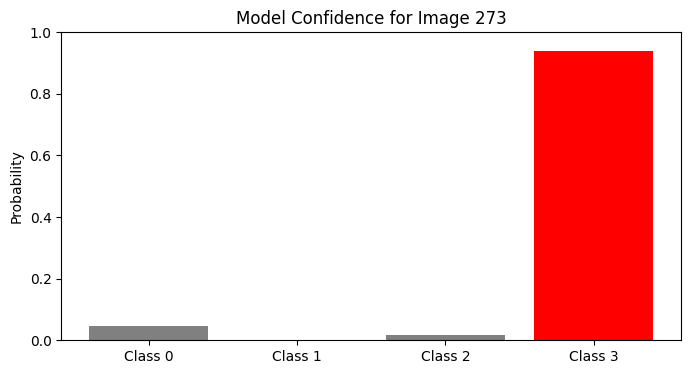

In [5]:
# --- 1. Setup SHAP ---
# Use a background set to speed up
background_mask = np.random.choice(X_train.shape[0], 100, replace=False)
background = X_train[background_mask]
explainer = shap.GradientExplainer(model, background)

# --- 2. Select a Test Sample ---
# Pick ONE specific image to tell a story about
idx = np.random.randint(0, len(X_test))
img_tensor = X_test[idx:idx+1]
true_label = y_test[idx]

print(f"Explaining Image Index: {idx} (True Class: {class_names[true_label]})")
print("Calculating SHAP values...")
shap_values = explainer.shap_values(img_tensor)

# --- PLOT 5: SHAP Image Plot (The 'Punch' Plot) ---
# Create a labels matrix to fix the IndexError
# We only have 1 sample here, so we repeat the class names list once
labels_matrix = np.array([class_names])

shap.image_plot(shap_values, -img_tensor, labels=labels_matrix)

# --- PLOT 6: Prediction Confidence ---
# Show what the model actually thought about this specific image
preds = model.predict(img_tensor)[0]

plt.figure(figsize=(8, 4))
plt.bar(class_names, preds, color=['red' if i == true_label else 'gray' for i in range(len(preds))])
plt.title(f"Model Confidence for Image {idx}")
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.show()

Found 4 unique Alzheimer's stages. Comparing them now...
Calculating SHAP values for the comparison batch...


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(4, 128, 128, 1))']
  warnings.warn(msg)



--- Comparative SHAP Analysis: Where does the AI look for each stage? ---


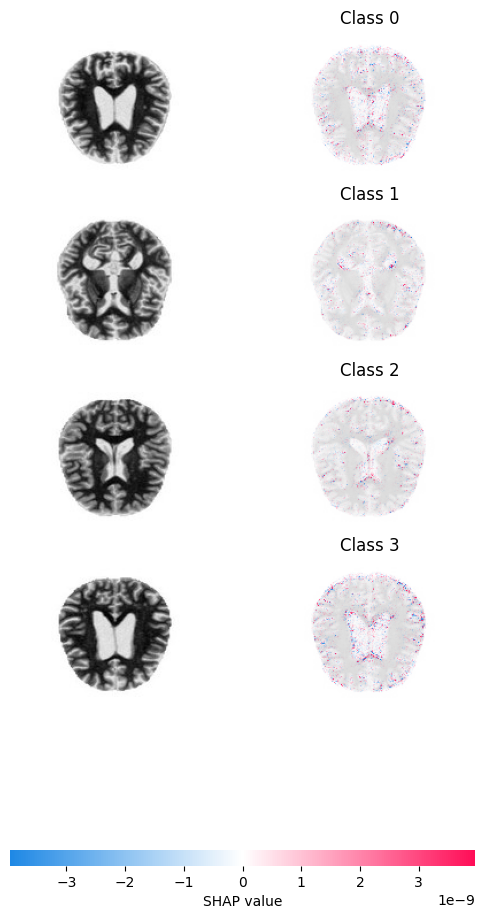

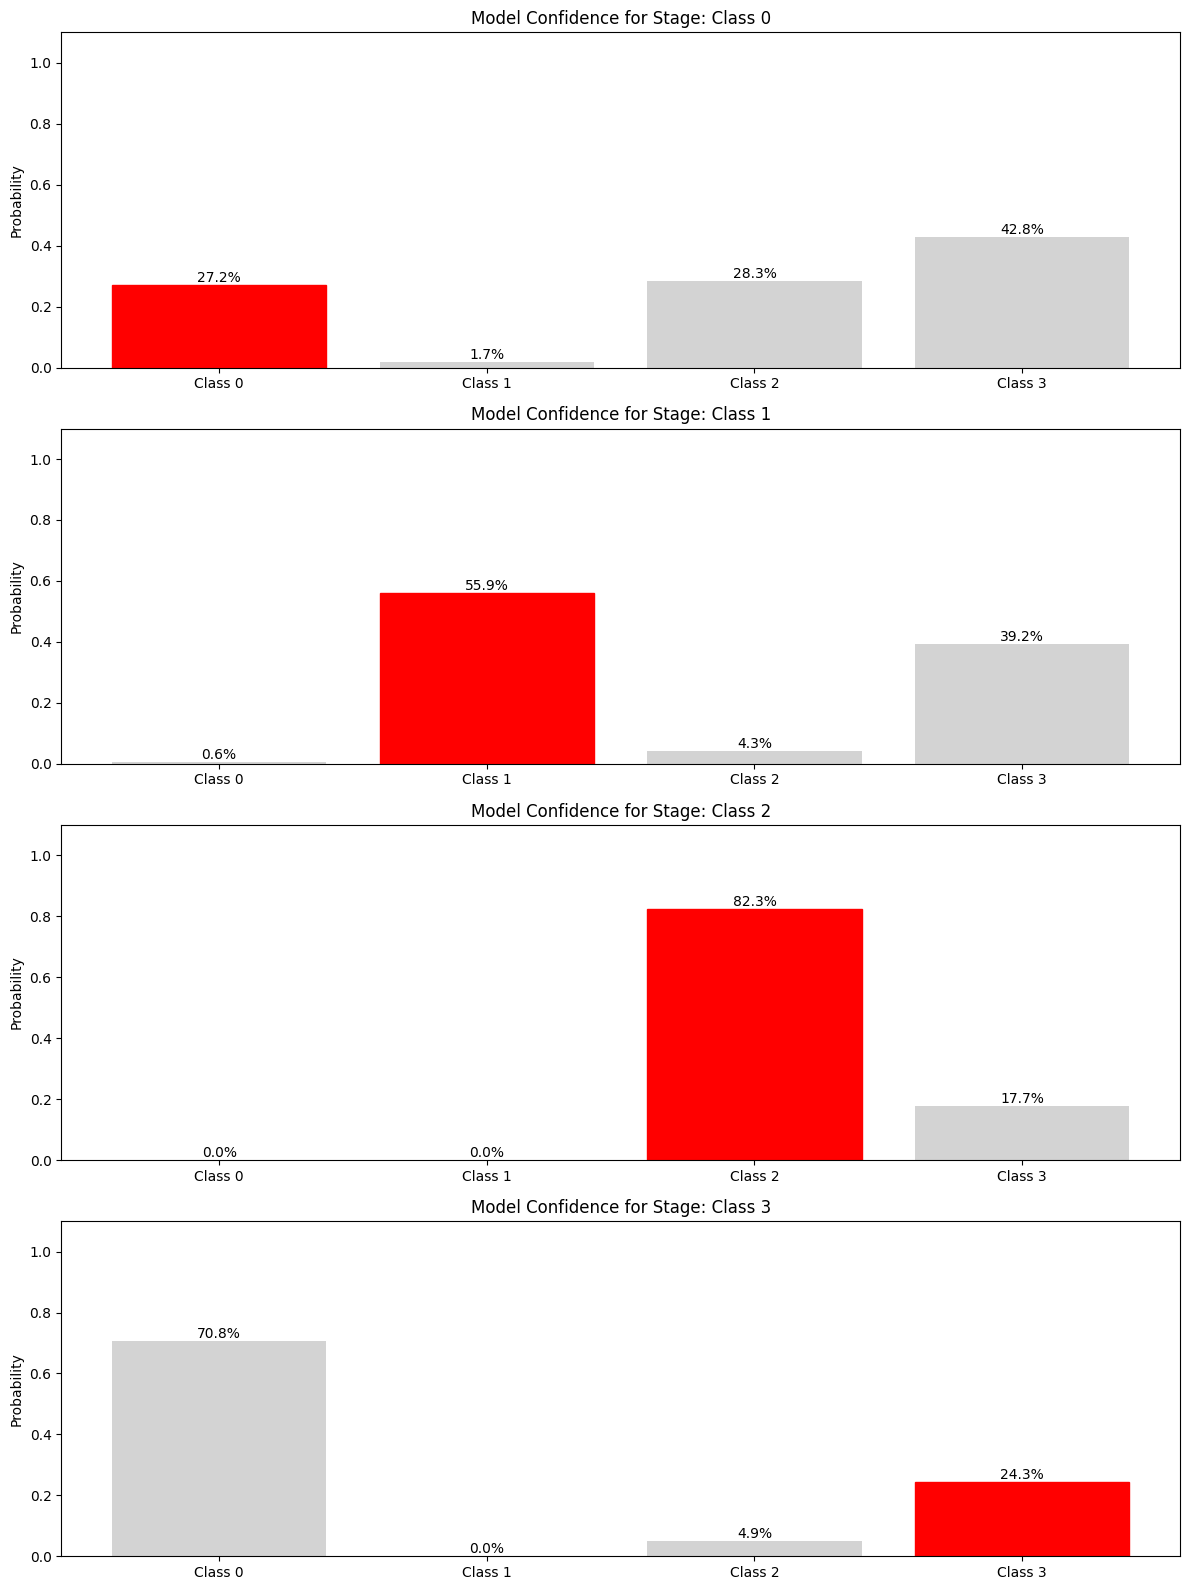

In [6]:
# --- STEP 6: Comparative Analysis of All Classes ---

# 1. Find one unique example for each class present in the test set
unique_classes = np.unique(y_test)
indices_to_explain = []

print(f"Found {len(unique_classes)} unique Alzheimer's stages. Comparing them now...")

for cls in unique_classes:
    # Find the first index in X_test that belongs to this specific class
    idx = np.where(y_test == cls)[0][0]
    indices_to_explain.append(idx)

# Create a batch of these representative images
X_samples = X_test[np.array(indices_to_explain)]
y_samples = y_test[np.array(indices_to_explain)]

# 2. Calculate SHAP values for this specific batch
print("Calculating SHAP values for the comparison batch...")
shap_values_batch = explainer.shap_values(X_samples)

# 3. Plot SHAP Images (The Comparison Plot)
# Create labels matrix: (num_samples, num_classes)
labels_matrix_batch = np.array([class_names for _ in range(len(X_samples))])

print("\n--- Comparative SHAP Analysis: Where does the AI look for each stage? ---")
# Plot: Each row is a different stage of Alzheimer's
shap.image_plot(shap_values_batch, -X_samples, labels=labels_matrix_batch)

# 4. Generate Confidence Bar Charts for each sample
plt.figure(figsize=(12, 4 * len(unique_classes)))

for i, idx in enumerate(indices_to_explain):
    # Get model prediction
    preds = model.predict(X_samples[i:i+1], verbose=0)[0]
    true_label = y_samples[i]
    true_name = class_names[true_label]

    # Plot
    plt.subplot(len(unique_classes), 1, i+1)
    # Color logic: Red for the Correct Class, Gray for others
    bars = plt.bar(class_names, preds, color=['lightgray' for _ in range(len(preds))])
    bars[true_label].set_color('red')

    # Add labels
    plt.title(f"Model Confidence for Stage: {true_name}")
    plt.ylabel("Probability")
    plt.ylim(0, 1.1)

    # Add text on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height*100:.1f}%',
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()

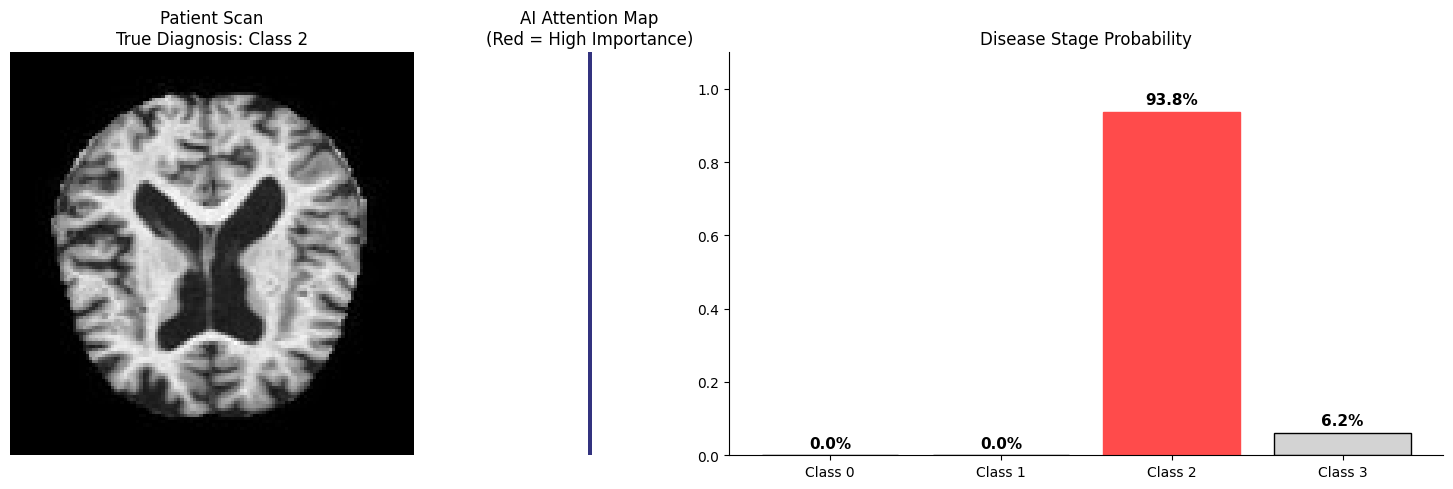

In [10]:
# --- CELL: INDIVIDUAL PATIENT DIAGNOSIS ---
import matplotlib.gridspec as gridspec

# 1. Select a random patient from the test set
idx = np.random.randint(0, len(X_test))
img_tensor = X_test[idx:idx+1]
true_label = y_test[idx]
true_name = class_names[true_label]

# 2. Get AI Prediction & Explanation
preds = model.predict(img_tensor, verbose=0)[0]
shap_values = explainer.shap_values(img_tensor)

# 3. Create a Professional Dashboard Layout
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1.5])

# Panel A: Original MRI (What the doctor sees)
ax0 = plt.subplot(gs[0])
ax0.imshow(img_tensor[0].reshape(128, 128), cmap='gray')
ax0.set_title(f"Patient Scan\nTrue Diagnosis: {true_name}")
ax0.axis('off')

# Panel B: AI 'Attention' (What the AI sees)
ax1 = plt.subplot(gs[1])
# SHAP plot needs a bit of a hack to plot on a specific axis, so we visualize the overlay manually
# Taking the sum of absolute SHAP values across classes to show "General Importance"
shap_sum = np.sum(np.abs(np.array(shap_values)[:, 0, :, :, 0]), axis=0)
ax1.imshow(img_tensor[0].reshape(128, 128), cmap='gray', alpha=0.5)
ax1.imshow(shap_sum, cmap='jet', alpha=0.6, vmin=0) # 'jet' gives the classic medical heatmap look
ax1.set_title("AI Attention Map\n(Red = High Importance)")
ax1.axis('off')

# Panel C: Confidence Score (Risk Assessment)
ax2 = plt.subplot(gs[2])
bars = ax2.bar(class_names, preds, color='lightgray', edgecolor='black')
bars[np.argmax(preds)].set_color('#ff4b4b') # Highlight prediction in Red
ax2.set_title("Disease Stage Probability")
ax2.set_ylim(0, 1.1)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Add percentage labels
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height*100:.1f}%', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 276ms/step


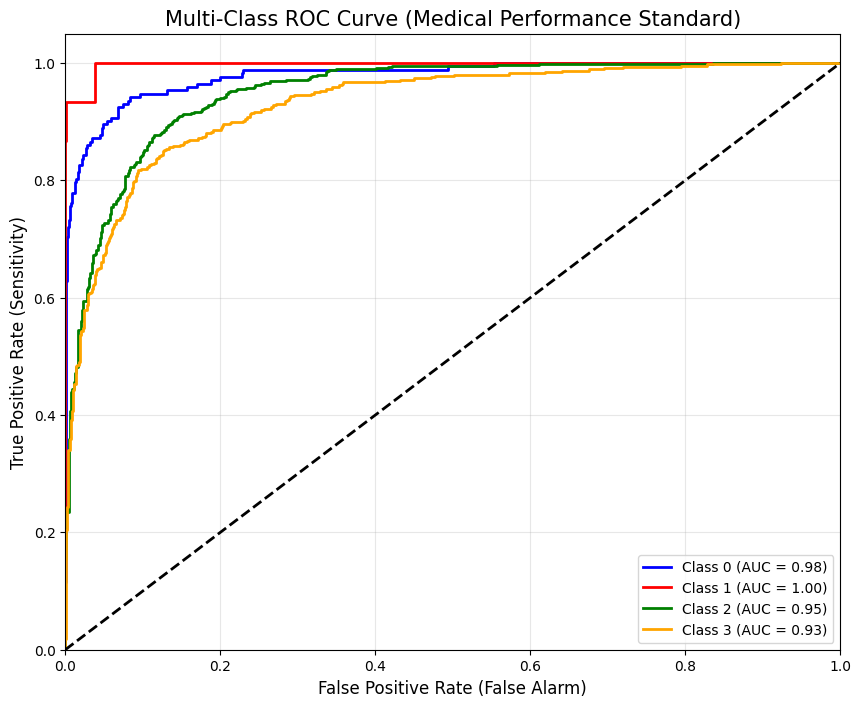

In [12]:
# --- CELL: ROC CURVES (MEDICAL STANDARD EVALUATION) ---
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# 1. Get predictions
y_pred_probs = model.predict(X_test)
y_test_bin = utils.to_categorical(y_test, num_classes)

# 2. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (False Alarm)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Multi-Class ROC Curve (Medical Performance Standard)', fontsize=15)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()